# Face Detection among images

In [1]:
# loading libraries
# System
import os
import joblib
from collections import Counter

# Image processing
import skimage
from skimage.transform import resize
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

# Data Processing
import numpy as np
import pandas as pd

# data viz
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [193]:
from resizedata import resize_data

### Data resizing

In [3]:
data_path = r'C:\Users\straw\Desktop\AIS\ProjectPool 2\Classification-images\Data\AnimalFace'
print(os.listdir(data_path))

['BearHead', 'CatHead', 'ChickenHead', 'CowHead', 'DeerHead', 'DogHead', 'DuckHead', 'EagleHead', 'ElephantHead', 'HumanHead', 'LionHead', 'MonkeyHead', 'MouseHead', 'Natural', 'PandaHead', 'PigeonHead', 'PigHead', 'RabbitHead', 'SheepHead', 'TigerHead', 'WolfHead']


In [156]:
pklname = 'output'
width = 80

In [4]:
include = {'CatHead', 'BearHead', 'ElephantHead', 'EagleHead', 'DeerHead', 'WolfHead', 'PandaHead'}

resize_data(path=data_path, pklname=pklname, include=include, width=width)

{'description': 'resized (80x80)animal images in rgb',
 'label': ['Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bear',
  'Bea

In [157]:
data = joblib.load(f'Output/{pklname}_{width}x{width}px.pkl')
 
print('Number of samples: ', len(data['data']))
print('Keys: ', list(data.keys()))
print('Description: ', data['description'])
print('Images shape: ', data['data'][0].shape)
print('Labels:', np.unique(data['label']))

Number of samples:  775
Keys:  ['description', 'label', 'filename', 'data']
Description:  resized (80x80)animal images in rgb
Images shape:  (80, 80, 3)
Labels: ['Bear' 'Cat' 'Deer' 'Eagle' 'Elephant' 'Panda' 'Wolf']


In [158]:
Counter(data['label'])

Counter({'Bear': 101,
         'Cat': 159,
         'Deer': 101,
         'Eagle': 97,
         'Elephant': 100,
         'Panda': 117,
         'Wolf': 100})

TypeError: 'AxesSubplot' object is not iterable

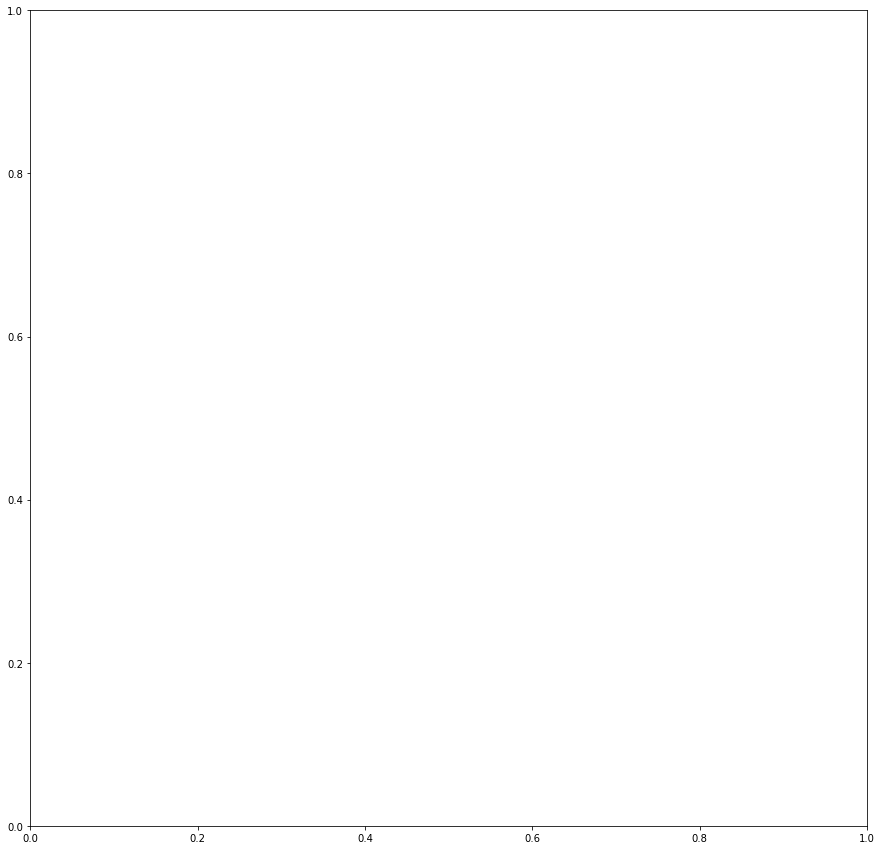

In [192]:
labels = np.unique(data2['label'])

fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,15)
for ax, label in zip(axes, labels):
    idx = data2['label'].index(label)
    ax.imshow(data2['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [191]:
data['data'][0].shape

(80, 80, 3)

In [163]:
data['label'][0]

'Bear'

In [187]:
X = np.array(data['data'])
y = np.array(data['label'])
X.shape

(775, 80, 80, 3)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

In [11]:
print(Counter(y))
print(Counter(y_train))
print(Counter(y_test))

Counter({'Cat': 159, 'Panda': 117, 'Bear': 101, 'Deer': 101, 'Elephant': 100, 'Wolf': 100, 'Eagle': 97})
Counter({'Cat': 127, 'Panda': 93, 'Deer': 81, 'Bear': 81, 'Wolf': 80, 'Elephant': 80, 'Eagle': 78})
Counter({'Cat': 32, 'Panda': 24, 'Wolf': 20, 'Bear': 20, 'Elephant': 20, 'Deer': 20, 'Eagle': 19})


Afin de s'assurer de l'obtention de distributions égales dans l'ensemble d'apprentissage et de test, il est possible d'utiliser le paramètre **stratify**. Celui-ci permet des échantillons représentatifs des données $y$. 

In [12]:
unique_y, counts_y = np.unique(y, return_counts=True)
unique_ytrain, counts_ytrain = np.unique(y_train, return_counts=True)
unique_ytest, counts_ytest = np.unique(y_test, return_counts=True)

In [13]:
trace1 = go.Bar(y=counts_y, x=unique_y, name='Dataset y')
trace2 = go.Bar(y=counts_ytrain, x=unique_ytrain, name='Dataset y_train')
trace3 = go.Bar(y=counts_ytest, x=unique_ytest, name='Dataset y_test')

data = [trace1, trace2, trace3]
layout = dict(title = 'Distributions des photos par dataset', yaxis = dict(title = 'Counts'), xaxis = dict(title = 'Labels'))
fig = dict(data = data, layout = layout)
iplot(fig)

In [13]:
trace2 = go.Bar(y=100*counts_ytrain/len(y_train), x=unique_ytrain, name='Dataset y_train')
trace3 = go.Bar(y=100*counts_ytest/len(y_test), x=unique_ytest, name='Dataset y_test')

data = [trace2, trace3]
layout = dict(title = 'Quantité relative de photos par dataset', yaxis = dict(title = '% Counts'), xaxis = dict(title = 'Labels'))
fig = dict(data = data, layout = layout)
iplot(fig)

## Test de HOG

In [14]:
dog = imread('Data/Long_haired_German_Sheppard.jpg', as_gray=True)

In [15]:
dog = rescale(dog, 1/10, mode='reflect')

In [16]:
dog_hog, dog_hog_img = hog(dog, pixels_per_cell=(8,8), cells_per_block=(3, 3), orientations=9, visualize=True, block_norm='L2-Hys')

In [17]:
print('Nombre des pixels :', dog.shape[0] * dog.shape[1])
print('Nombre des features de hog :', dog_hog.shape[0])

Nombre des pixels : 121706
Nombre des features de hog : 136080


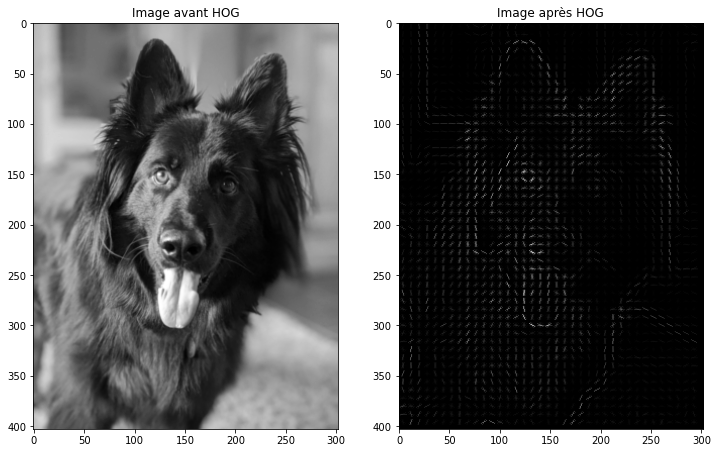

In [18]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(dog, cmap='gray')
plt.title('Image avant HOG')
plt.subplot(1,2,2)
plt.imshow(dog_hog_img, cmap='gray')
plt.title('Image après HOG')
plt.show()

## Création des transformateurs

In [19]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        T = np.array([skimage.color.rgb2gray(img) for img in X])
        return T

class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Calculates hog features for each img
    """
    def __init__(self, y=None, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
    
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        def local_hog(X):
            orientations = self.orientations
            pixels_per_cell = self.pixels_per_cell
            cells_per_block = self.cells_per_block
            block_norm = self.block_norm
            hog_results = hog(X, orientations, pixels_per_cell, cells_per_block, block_norm)
            return hog_results
        
        try:
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

## Entrainement du classifieur

In [20]:
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()

# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(620, 576)


In [23]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier()

In [24]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [25]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True  True False  True  True  True  True  True  True  True  True
  True False False  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  89.03225806451613


[[14  1  0  0  2  1  2]
 [ 1 30  0  0  0  0  1]
 [ 0  0 19  0  1  0  0]
 [ 0  1  0 19  0  0  0]
 [ 3  0  0  1 16  0  0]
 [ 0  1  0  0  0 22  0]
 [ 2  0  0  0  0  0 18]]


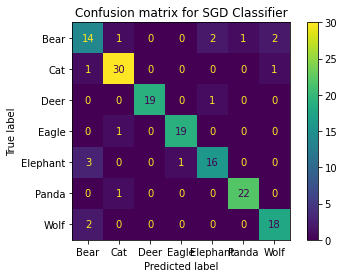

In [26]:
disp = plot_confusion_matrix(sgd_clf, X_test_prepared, y_test)
print(disp.confusion_matrix)
plt.title('Confusion matrix for SGD Classifier')
plt.show()

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Bear       0.70      0.70      0.70        20
         Cat       0.91      0.94      0.92        32
        Deer       1.00      0.95      0.97        20
       Eagle       0.95      0.95      0.95        20
    Elephant       0.84      0.80      0.82        20
       Panda       0.96      0.96      0.96        23
        Wolf       0.86      0.90      0.88        20

    accuracy                           0.89       155
   macro avg       0.89      0.88      0.89       155
weighted avg       0.89      0.89      0.89       155



# Pipeline de prétraitement

In [28]:
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(pixels_per_cell=(14, 14), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')),
    ('scalify', StandardScaler()),
    ('classify', svm.SVC(kernel='linear'))
])

clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct :', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))

Percentage correct : 88.38709677419355


# Gridsearch

Dans la grille ci-dessous, je teste les différents paramètres en commentant certains d'eux et en executant les autres afin de trouver les optimaux.

In [62]:
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)],
        'scalify': [
            StandardScaler(),
            Normalizer(),
            MinMaxScaler(),
            #RobustScaler(),
            #MaxAbsScaler()
        ],
        'classify': [
            SGDClassifier(max_iter=1000, tol=1e-3),
            #svm.SVC(kernel='linear'),
            svm.SVC(kernel='poly'),
            #svm.SVC(kernel='sigmoid'),
            #svm.SVC(kernel='precomputed'),
            #svm.SVC(),
            GaussianNB(),
            #MultinomialNB(), 
            #BernoulliNB()
        ]
    }
]

In [63]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  7.5min finished


In [54]:
# save the model to disk
joblib.dump(grid_res, 'Output\models\hog_models.pkl')

['Output\\models\\hog_models.pkl']

In [64]:
print('Best Estimator :',grid_res.best_estimator_)

Best Estimator : Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer()), ('scalify', Normalizer()),
                ('classify', SVC(kernel='poly'))])


In [65]:
print('Best Score :', grid_res.best_score_)

Best Score : 0.9451612903225806


In [66]:
print('Best parameters :',grid_res.best_params_)

Best parameters : {'classify': SVC(kernel='poly'), 'hogify__cells_per_block': (3, 3), 'hogify__orientations': 9, 'hogify__pixels_per_cell': (8, 8), 'scalify': Normalizer()}


In [67]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))

Percentage correct:  96.7741935483871


[[18  0  0  0  0  0  2]
 [ 0 32  0  0  0  0  0]
 [ 0  0 20  0  0  0  0]
 [ 0  0  0 20  0  0  0]
 [ 0  0  0  1 19  0  0]
 [ 0  0  0  0  0 23  0]
 [ 2  0  0  0  0  0 18]]


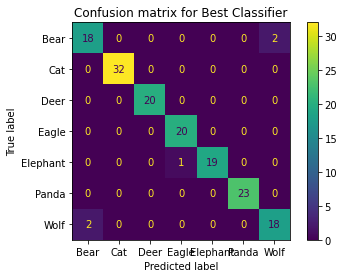

In [68]:
disp = plot_confusion_matrix(grid_res.best_estimator_, X_test, y_test)
print(disp.confusion_matrix)
plt.title('Confusion matrix for Best Classifier')
plt.show()

In [69]:
print(classification_report(y_test, best_pred))

              precision    recall  f1-score   support

        Bear       0.90      0.90      0.90        20
         Cat       1.00      1.00      1.00        32
        Deer       1.00      1.00      1.00        20
       Eagle       0.95      1.00      0.98        20
    Elephant       1.00      0.95      0.97        20
       Panda       1.00      1.00      1.00        23
        Wolf       0.90      0.90      0.90        20

    accuracy                           0.97       155
   macro avg       0.96      0.96      0.96       155
weighted avg       0.97      0.97      0.97       155



Les meilleurs paramètres identifiés par le GridSearch sont les suivants :
* **hogify__cells_per_block**: (3, 3)
* **hogify__orientations**: 9
* **hogify__pixels_per_cell**: (8, 8)
* **scalify**: Normalizer()
* **classify**: SVC(kernel='poly')

- Naive Bayes suppose que les features sont indépendantes.
- Les SVMs utilisant le noyau de la fonction de base radiale sont susceptibles d'être plus performants car ils peuvent gérer les non-linéarités dans les données.

In [183]:
l = []
for i in range(0, len(data2['data'])):
    if data2['data'][i].shape != (80, 80, 3):
        
        l.append(i)
print(l)

[2, 5, 128, 251, 374, 497, 620, 743, 817, 840, 863, 886, 889, 912, 935, 958, 981, 1004, 1027, 1050, 1073, 1096, 1119, 1122, 1145, 1168, 1191, 1214, 1237, 1260, 1283, 1306, 1329, 1352, 1355, 1499, 1622, 1745, 1991]


In [184]:
for e in l:
    data2['data'].pop(e)
    data2['label'].pop(e)